In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

api = wandb.Api()
ENT = "TomFrederik"
PROJ = "MT-ToyTask-Dreamer"
JOB_ID = "9749161" #NOTE <-- change this for new runs

def gen_run_id_list(job_id):
    my_list = []
    for setting_num in range(21):
        for seed_num in range(3):
            my_list.append(f"setting_{setting_num}_seed_{seed_num}_job_{job_id}")
    return my_list

def fetch_last_loss(run_id: str, loss_name: str = "tuning_loss") -> float:
    run = api.run(f"{ENT}/{PROJ}/{run_id}")
    return run.history(keys=[f'Validation/{loss_name}']).iloc[-1][f'Validation/{loss_name}']


def fetch_loss_list_per_setting(job_id, loss_name: str = "tuning_loss"):
    out_dict = dict()
    for setting_num in tqdm(range(21)):
        loss_list = []
        for seed_num in range(3):
            run_id = f"setting_{setting_num}_seed_{seed_num}_job_{job_id}"
            loss = fetch_last_loss(run_id, loss_name)
            loss_list.append(loss)
        out_dict[setting_num] = loss_list
    return out_dict

def compute_mean_std_per_setting(loss_dict):
    out_dict = dict()
    for key, val in loss_dict.items():
        mean = np.mean(val)
        std = np.std(val, ddof=1)
        out_dict[key] = (mean, std)
    return out_dict

In [2]:
# run id lists per setting
no_05 = [2, 4, 6]
yes_05 = [0, 1, 3, 5]
no_075 = [9, 11, 13]
yes_075 = [7, 8, 10, 12]
no_1 = [16, 18, 20]
yes_1 = [14, 15, 17, 19]

In [10]:
# loss_name = "value_prefix_loss"
loss_name = "tuning_loss"
mean_std_per_setting = compute_mean_std_per_setting(fetch_loss_list_per_setting(JOB_ID, loss_name))

100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


In [11]:
print(mean_std_per_setting)

{0: (0.10129226744174957, 0.007992197419365646), 1: (0.26374512414137524, 0.07911688305071249), 2: (0.10026899476846059, 0.010192559659158341), 3: (0.6843811670939127, 0.4430093107874078), 4: (0.10935833056767781, 0.0026276202027611783), 5: (1.610611120859782, 0.6858852504606935), 6: (0.15997632841269174, 0.014811016735992645), 7: (0.11394721517960231, 0.0062638613758421256), 8: (0.40511083602905273, 0.20820648731861122), 9: (0.0941091999411583, 0.016957228732643288), 10: (0.8892449140548706, 0.6463936093958297), 11: (0.11286004384358723, 0.015789839004682706), 12: (1.6084152062733967, 0.5407566633828629), 13: (0.14035498599211374, 0.009382883630991061), 14: (0.1081094741821289, 0.015385847285363538), 15: (0.3707532584667206, 0.06441567883144902), 16: (0.11405182878176372, 0.008193644822654278), 17: (0.7682286500930786, 0.13528964467274784), 18: (0.13300399978955588, 0.011832310365735057), 19: (1.6330829858779907, 0.287708237402175), 20: (0.1467626988887787, 0.01231519578888124)}


In [12]:
test_only_true_view_05 = [mean_std_per_setting[key] for key in yes_05]
test_only_true_view_075 = [mean_std_per_setting[key] for key in yes_075]
test_only_true_view_1 = [mean_std_per_setting[key] for key in yes_1]

test_only_false_view_05 = [mean_std_per_setting[key] for key in no_05]
test_only_false_view_075 = [mean_std_per_setting[key] for key in no_075]
test_only_false_view_1 = [mean_std_per_setting[key] for key in no_1]

In [13]:
print(test_only_true_view_05)

[(0.10129226744174957, 0.007992197419365646), (0.26374512414137524, 0.07911688305071249), (0.6843811670939127, 0.4430093107874078), (1.610611120859782, 0.6858852504606935)]


In [14]:
xticks_yes = np.array([0, 0.1, 0.2, 0.5])
xticks_no = np.array([0.1, 0.2, 0.5])
plot_kwargs = dict(width=0.025, capsize=4)

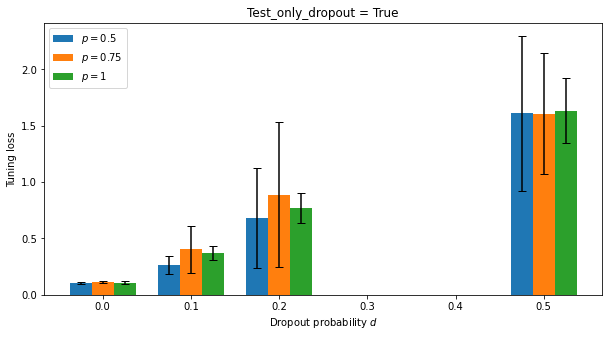

In [17]:
# eval for test_only true
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(xticks_yes-0.025, [x[0] for x in test_only_true_view_05], yerr=[x[1] for x in test_only_true_view_05], label=r"$p=0.5$", **plot_kwargs)
ax.bar(xticks_yes, [x[0] for x in test_only_true_view_075], yerr=[x[1] for x in test_only_true_view_075], label=r"$p=0.75$", **plot_kwargs)
ax.bar(xticks_yes+0.025, [x[0] for x in test_only_true_view_1], yerr=[x[1] for x in test_only_true_view_1], label=r"$p=1$", **plot_kwargs)
plt.title("Test_only_dropout = True")
# plt.yscale("log")
plt.xlabel(r"Dropout probability $d$")
plt.ylabel("Tuning loss")
plt.legend()

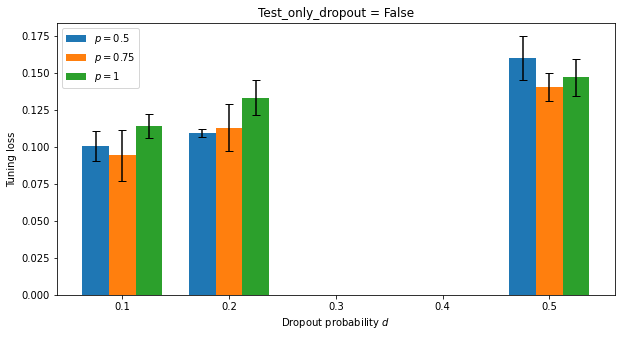

In [18]:
# eval for test_only false
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(xticks_no-0.025, [x[0] for x in test_only_false_view_05], yerr=[x[1] for x in test_only_false_view_05], label=r"$p=0.5$", **plot_kwargs)
ax.bar(xticks_no, [x[0] for x in test_only_false_view_075], yerr=[x[1] for x in test_only_false_view_075], label=r"$p=0.75$", **plot_kwargs)
ax.bar(xticks_no+0.025, [x[0] for x in test_only_false_view_1], yerr=[x[1] for x in test_only_false_view_1], label=r"$p=1$", **plot_kwargs)
plt.title("Test_only_dropout = False")
# plt.yscale("log")
plt.xlabel(r"Dropout probability $d$")
plt.ylabel("Tuning loss")
plt.legend()